# News Headlines Dataset For Sarcasm Detection


# Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU, BatchNormalization, Dropout
import tensorflow as tf

## Check for GPU

In order for our deep learning models to run as fast as possible, we'll need access to a GPU.

In Google Colab, you can set this up by going to Runtime -> Change runtime type -> Hardware accelerator -> GPU.

After selecting GPU, you may have to restart the runtime.

In [2]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-40f1c4bf-08e9-2f25-076b-2ffbd5c71839)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script containing our helper functions can be [found on GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py).

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-15 14:41:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-15 14:41:22 (66.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Download a text dataset

Let's start by download a text dataset. We'll be using the [News Headlines Dataset For Sarcasm Detection](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection) datset from Kaggle which contains news headlines if they are sarcastic or not. 


> 🔑 **Note:** The project has been inspired by the research paper (https://arxiv.org/pdf/1908.07414.pdf) and all the inspiration and credit goes to the author of the research paper.

In [ ]:
# Download data
data = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)

## Visualizing a text dataset

Once you've acquired a new dataset to work with, what should you do first?

Explore it? Inspect it? Verify it? Become one with it?

All correct.


In [ ]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


The training data we downloaded is probably shuffled already. But just to be sure, let's shuffle it again.

In [ ]:
# Shuffle training dataframe
data_shuffled = data.sample(frac=1, random_state=42) # shuffle with random_state = 42 for reproducibility
data_shuffled.head()

,is_sarcastic,headline,article_link
27927,0,states slow to shut down weak teacher educatio...,https://www.huffingtonpost.com/entry/teacher-e...
1660,1,drone places fresh kill on steps of white house,https://www.theonion.com/drone-places-fresh-ki...
96,1,report: majority of instances of people gettin...,https://www.theonion.com/report-majority-of-in...
6237,1,"sole remaining lung filled with rich, satisfyi...",https://local.theonion.com/sole-remaining-lung...
6650,0,the gop's stockholm syndrome,https://www.huffingtonpost.com/entry/the-gops-...


In [ ]:
# Check the number of samples in our dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


Let's check how many examples of each target we have.

In [ ]:
# How many examples of each class?
data_shuffled.is_sarcastic.value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

Since we have two target values, we're dealing with a **binary classification** problem.

It's fairly balanced too, about 55% negative class (`target = 0`) and 45% positive class (`target = 1`).

Where, 

* `1` = the tweet is sarcastic
* `0` = the tweet is not sarcastic

And what about the total number of samples we have?

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(data)-5) # create random indexes not higher than the total number of samples
for row in data_shuffled[["headline", "is_sarcastic"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(Sarcasm)" if target > 0 else "(Not Sarcasm)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (Sarcasm)
Text:
north korea claims new long range missile has ability to fly right up in the air, not unlike a bird or a fly

---

Target: 0 (Not Sarcasm)
Text:
6 reasons why trump's wall is even dumber than most of trump's other ideas

---

Target: 1 (Sarcasm)
Text:
god recalls 1983 speedboat accident that sent him to heaven

---

Target: 0 (Not Sarcasm)
Text:
is the southern baptist church having an identity crisis, or am i?

---

Target: 1 (Sarcasm)
Text:
congress launches national congress-awareness week

---



### Split data into training and validation sets

Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.

When our model trains (tries patterns in the samples), it'll only see data from the training set and we can see how it performs on unseen data using the validation set.

We'll convert our splits from pandas Series datatypes to lists of strings (for the text) and lists of ints (for the labels) for ease of use later.

To split our training dataset and create a validation dataset, we'll use Scikit-Learn's [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method and dedicate 10% of the training samples to the validation set.

In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(data_shuffled["headline"].to_numpy(),
                                                                            data_shuffled["is_sarcastic"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(25757, 25757, 2862, 2862)

In [ ]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['woman going to take quick break after filling out name, address on tax forms',
        'last people left at party a ragtag assembly of friends of friends',
        'poll: duckworth lead over kirk shrivels',
        'groom getting cold feet about bachelor party',
        'why peyton manning badly needs to win super bowl 50',
        "corpses of 'lone ranger' producers hung from hollywood blvd. street lights as warning to others",
        'china excludes same-sex couples from domestic violence law',
        'leonardo dicaprio morphs back into hairy, overweight iowan after finally receiving oscar',
        "researchers no closer to understanding what the fuck you're talking about",
        "study finds older dads may have 'geekier' sons"], dtype=object),
 array([1, 1, 0, 1, 0, 1, 0, 1, 1, 0]))

### Text vectorization (tokenization)

Enough talking about tokenization and embeddings, let's create some.

We'll practice tokenzation (mapping our words to numbers) first.

To tokenize our words, we'll use the helpful preprocessing layer [`tf.keras.layers.experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens. 
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.

Let's see it in action.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_tokens` and `output_sequence_length`.

For `max_tokens` (the number of words in the vocabulary), multiples of 10,000 (`10,000`, `20,000`, `30,000`) or the exact number of unique words in your text (e.g. `32,179`) are common values.

For our use case, we'll use `10,000`.

And for the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [ ]:
# Find average number of tokens (words) in training sequences
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

10

Now let's create another `TextVectorization` object using our custom parameters.

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length = 28000 # max number of words to have in our vocabulary
max_length = 30 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

Beautiful!

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

Training data mapped! Let's try our `text_vectorizer` on a custom sentence (one similar to what you might see in the training data).

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "So It Seems Like This Internet Thing Is Here To Stay, Huh?" # sample sentence
text_vectorizer([sample_sentence]) # tokenize the sample sentence

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[  107,    27,  1860,    55,    21,   567,   208,    11,   424,
            2,  1228, 12762,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]])>

Wonderful, it seems we've got a way to turn our text into numbers (in this case, word-level tokenization). Notice the 0's at the end of the returned tensor, this is because we set `output_sequence_length=30`, meaning no matter the size of the sequence we pass to `text_vectorizer`, it always returns a sequence with a length of 30.

How about we try our `text_vectorizer` on a few random sentences?

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
bernie sanders requests kentucky primary recanvass      

Vectorized version:


<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[  404,   278,  3886,  2934,  1194, 18290,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]])>

Looking good!

Finally, we can check the unique tokens in our vocabulary using the `get_vocabulary()` method.

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}") # number of words in vocab
print(f"Top 5 most common words: {top_5_words}")  # top 5 most common words
print(f"Bottom 5 least common words: {bottom_5_words}")  # bottom 5 least common words

Number of words in vocab: 28000
Top 5 most common words: ['', '[UNK]', 'to', 'of', 'the']
Bottom 5 least common words: ['2085', '2078', '2070', '2065', '205000']


### Creating an Embedding using an Embedding Layer

We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. 

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

Knowing these, let's make an embedding layer.

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim= 128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             embeddings_regularizer=None, # Regularizer function applied to the embeddings matrix
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

Excellent, notice how `embedding` is a TensoFlow layer? This is important because we can use it as part of a model, meaning its parameters (word representations) can be updated and improved as the model learns.

How about we try it out on a sample sentence?

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
the conservative reform movement's raging contradiction      

Embedded version:


<tf.Tensor: shape=(1, 30, 128), dtype=float32, numpy=
array([[[-0.04364428,  0.02437404, -0.03696011, ..., -0.04763393,
          0.02931459,  0.0068561 ],
        [-0.00057185, -0.02672013, -0.02819778, ...,  0.019741  ,
         -0.03810944, -0.01872007],
        [ 0.02886024, -0.04978222,  0.00995754, ..., -0.01021207,
          0.04130098,  0.02583535],
        ...,
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097]]], dtype=float32)>

Each token in the sentence gets turned into a length 128 feature vector.

In [ ]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-4.36442755e-02,  2.43740417e-02, -3.69601138e-02,  1.25270747e-02,
        3.80215310e-02,  7.01111555e-03,  7.53332302e-03, -2.80847438e-02,
       -2.27943808e-03,  4.93877269e-02,  3.36292647e-02, -2.20247749e-02,
       -2.70647053e-02, -3.78299467e-02, -1.23208873e-02, -4.84758615e-03,
        2.59770416e-02, -3.45488414e-02,  1.47561468e-02,  2.67946459e-02,
        3.31937335e-02, -2.05505975e-02,  3.09475772e-02,  2.63909213e-02,
        1.76474564e-02,  2.42445357e-02,  1.45293735e-02, -4.61531654e-02,
       -1.55401118e-02, -3.50387804e-02, -1.15318298e-02, -2.31770873e-02,
       -5.79435751e-03,  3.35673727e-02,  1.88197754e-02,  3.83131988e-02,
        1.77796744e-02,  3.34728882e-03, -6.53777272e-03,  2.07362808e-02,
        4.58942689e-02, -4.02756818e-02,  4.23009060e-02,  3.20951678e-02,
        9.82693583e-03, -4.56042998e-02,  6.32042810e-03, -9.25098732e-03,
        3.05483676e-02,  1.58221461e-02,  2.25603469

These values might not mean much to us but they're what our computer sees each word as. When our model looks for patterns in different samples, these values will be updated as necessary.

> 🔑 **Note:** The previous two concepts (tokenization and embeddings) are the foundation for many NLP tasks. So if you're not sure about anything, be sure to research and conduct your own experiments to further help your understanding.

The benefit of using a shallow model like Multinomial Naive Bayes is that training is very fast.

Let's evaluate our model and find our baseline metric.

How about we make some predictions with our baseline model?

### Creating an evaluation function for our model experiments

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:
* Accuracy
* Precision
* Recall
* F1-score

> 🔑 **Note:** Since we're dealing with a classification problem, the above metrics are the most appropriate. If we were working with a regression problem, other metrics such as MAE (mean absolute error) would be a better choice.

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

# Creating ModelCheckpoint callbacks to save model's progress

In [ ]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

# Creating EarlyStopping in case the model does not improve after multiple epochs

## Stop training when a monitored metric has stopped improving.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping( 
    monitor="val_loss", # stop training when validation loss does not improve
    min_delta=0, # minimum change in the monitored quantity to qualify as an improvement
    patience=5, # number of epochs with no improvement after which training will be stopped
    verbose=5, # verbosity mode
    mode="auto", # one of {auto, min, max}
    baseline=None, # used in auto mode
    restore_best_weights=False, # restore model weights from the epoch with the best value of the monitored quantity
)

# ReduceLROnPlateau
## Reduce learning rate when a metric has stopped improving.



In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", # metric quantity to be monitored
    factor=0.05, # multiply by this factor when learning rate is reduced
    patience=2, # number of epochs with no improvement after which learning rate will be reduced
    verbose=5, # verbosity mode
    mode="auto", # one of {auto, min, max}
    min_delta=0.0001, # threshold for measuring the new optimum
    cooldown=0, # number of epochs to wait before resuming normal operation after lr has been reduced
    min_lr=0, # lower bound on the learning rate
)

Now we've got a TensorBoard callback function ready to go, let's build our first deep model.

Since we'll be doing this kind of comparison (baseline compared to new model) quite a few times, let's create a function to help us out. 

In [ ]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

#compare_baseline_to_new_results(baseline_results=baseline_results, 
 #                               new_model_results=model_1_results)

And now let's get our embedding layer's weights (these are the numerical representations of each word).

### Baseline Model: Bidirectonal RNN model 

With all this talk of what RNN's are and what they're good for, I'm sure you're eager to build one.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).



In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers # import layers from Keras
baseline_model_embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                                     output_dim=128, # set size of embedding vector
                                     embeddings_initializer="uniform", # default, intialize randomly
                                     input_length=max_length, # how long is each input
                                     name="embedding_2") # name of the embedding layer


# Create Bidirectional LSTM model
inputs = layers.Input(shape=(1,), dtype="string") # input layer
x = text_vectorizer(inputs) # convert input to numerical representation
x = baseline_model_embedding(x) # pass through embedding layer
print(x.shape)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.Dropout(0.2)(x) # adding a dropout layer to prevent overfitting
x = layers.BatchNormalization()(x) # normalize the output of the RNN
x = layers.Bidirectional(layers.LSTM(64))(x) # return vector for whole sequence
x = layers.Dropout(0.2)(x) # adding a dropout layer to prevent overfitting
x = layers.BatchNormalization()(x) # normalize the output of the RNN
print(x.shape) 
x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x) # output layer
baseline_model = tf.keras.Model(inputs, outputs, name="baseline_model_LSTM") # create model

(None, 30, 128)
(None, 128)


> 🔑 **Note:** Reading the documentation for the [TensorFlow LSTM layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM), you'll find a plethora of parameters. Many of these have been tuned to make sure they compute as fast as possible. The main ones you'll be looking to adjust are `units` (number of hidden units) and `return_sequences` (set this to `True` when stacking LSTM or other recurrent layers).

Now we've got our LSTM model built, let's compile it using `"binary_crossentropy"` loss and the Adam optimizer.

In [ ]:
# Compile model
baseline_model.compile(loss="binary_crossentropy", # loss function
                optimizer=tf.keras.optimizers.Adam(), # optimizer
                metrics=["accuracy"]) # metrics to be evaluated during training

And before we fit our model to the data, let's get a summary.

In [ ]:
baseline_model.summary() # print model summary

Model: "baseline_model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 30, 128)           3584000   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          263168    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 batch_normalization (BatchN  (None, 30, 256)  

Looking good! You'll notice a fair few more trainable parameters here than our simple ML algorithms


In [ ]:
# Fit model
baseline_history = baseline_model.fit(train_sentences, # training data
                              train_labels, # training labels
                              epochs=15, # number of epochs
                              validation_data=(val_sentences, val_labels), # validation data
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM"), model_checkpoint, early_stopping, reduce_lr])

Saving TensorBoard log files to: model_logs/LSTM/20211115-144132
Epoch 1/15
805/805 [==============================] - 55s 51ms/step - loss: 0.3945 - accuracy: 0.8193 - val_loss: 0.3028 - val_accuracy: 0.8718 - lr: 0.0010
Epoch 2/15
805/805 [==============================] - 39s 49ms/step - loss: 0.1657 - accuracy: 0.9361 - val_loss: 0.3470 - val_accuracy: 0.8648 - lr: 0.0010
Epoch 3/15
805/805 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9707
Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
805/805 [==============================] - 40s 49ms/step - loss: 0.0845 - accuracy: 0.9707 - val_loss: 0.6802 - val_accuracy: 0.7956 - lr: 0.0010
Epoch 4/15
805/805 [==============================] - 40s 49ms/step - loss: 0.0343 - accuracy: 0.9894 - val_loss: 0.5254 - val_accuracy: 0.8683 - lr: 5.0000e-05
Epoch 5/15
804/805 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.9940
Epoch 00005: ReduceLROnPlateau reducing l

Nice! We've got our first trained RNN model using LSTM cells. Let's make some predictions with it.

The same thing will happen as before, due to the sigmoid activiation function in the final layer, when we call the `predict()` method on our model, it'll return prediction probabilities rather than classes.

In [ ]:
# Make predictions on the validation dataset
baseline_model_pred_probs = baseline_model.predict(val_sentences) # make predictions
baseline_model_pred_probs.shape, baseline_model_pred_probs[:10] # view the first 10

((2862, 1), array([[9.9728823e-01],
        [3.5869936e-04],
        [9.9995339e-01],
        [9.9998832e-01],
        [9.9960870e-01],
        [5.9503235e-04],
        [9.7783573e-04],
        [6.1323649e-01],
        [5.2577612e-05],
        [9.9785548e-01]], dtype=float32))

We can turn these prediction probabilities into prediction classes by rounding to the nearest integer (by default, prediction probabilities under 0.5 will go to 0 and those over 0.5 will go to 1).

In [ ]:
# Round out predictions and reduce to 1-dimensional array
baseline_model_preds = tf.squeeze(tf.round(baseline_model_pred_probs)) 
baseline_model_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 1., 1., 0., 0., 1., 0., 1.], dtype=float32)>

Beautiful, now let's use our `calcuate_results()` function to evaluate our LSTM model and our `compare_baseline_to_new_results()` function to compare it to our baseline model.

In [ ]:
# Calculate LSTM model results
baseline_model_results = calculate_results(y_true=val_labels, 
                                    y_pred=baseline_model_preds)
baseline_model_results

{'accuracy': 86.44304682040531,
 'f1': 0.8644692006156373,
 'precision': 0.866218465268858,
 'recall': 0.8644304682040531}

Now we've got these two objects, we can use the [Embedding Projector tool](http://projector.tensorflow.org/_) to visualize our embedding. 

To use the Embedding Projector tool, we need two files:
* The embedding vectors (same as embedding weights).
* The meta data of the embedding vectors (the words they represent - our vocabulary).

Right now, we've got of these files as Python objects. To download them to file, we're going to [use the code example available on the TensorFlow word embeddings tutorial page](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk).


In [ ]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
#embed_weights = baseline_model.get_layer("embedding_1").get_weights()[0]
#print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

In [ ]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0: 
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

# MODEL 1 : Using Pretrained Embeddings (transfer learning for NLP)

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through **transfer learning**. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4) (a great resource containing a plethora of pretrained model resources for a variety of tasks).

> 🔑 **Note:** There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.



### Model 1: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

Let's load the Universal Sentence Encoder model and test it on a couple of sentences.

In [ ]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # Load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."]) 

print(embed_samples[0][:50])

tf.Tensor(
[ 0.02285576  0.05599008 -0.02142934 -0.03681325 -0.01647731  0.01036584
  0.01865435  0.01320562  0.06016935 -0.0036779  -0.03153399 -0.00575823
  0.03084559  0.04710538  0.05997398 -0.05374786 -0.04809381 -0.02493408
  0.00567767 -0.00865088 -0.08051635 -0.05007069  0.05378757  0.01312216
 -0.02426482  0.01372254  0.05393068 -0.01322597  0.06902386 -0.04406415
  0.02934264 -0.05961558 -0.01963601  0.00949474  0.04088591  0.05860829
 -0.01390968 -0.02457503 -0.00445435 -0.04764604  0.08532364 -0.00186264
 -0.00492015  0.02860365 -0.01262604  0.00661173 -0.04614464  0.06792253
  0.02672658 -0.04150194], shape=(50,), dtype=float32)


In [ ]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

We can convert the TensorFlow Hub USE module into a Keras layer using the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

> 🔑 **Note:** Due to the size of the USE TensorFlow Hub module, it may take a little while to download. Once it's downloaded though, it'll be cached and ready to use. And as with many TensorFlow Hub modules, there is a ["lite" version of the USE](https://tfhub.dev/google/universal-sentence-encoder-lite/2) which takes up less space but sacrifices some performance and requires more preprocessing steps. However, depending on your available compute power, the lite version may be better for your application use case.

In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # whether or not the layer is trainable. If False, the layer will not be trained during training.
                                        name="USE") 

Beautiful! Now we've got the USE as a Keras layer, we can use it in a Keras Sequential model.

In [ ]:
# Creating the final model
inputs = layers.Input(shape = (), dtype = 'string',name = 'input_layer')

x = sentence_encoder_layer(inputs)
x = layers.Dense(256, activation="relu")(x) # optional dense layer on top of output of LSTM cell
x = layers.Dropout(0.2)(x) # adding dropout layer to prevent overfitting
x = layers.BatchNormalization()(x) # normalize the output of the RNN
x = layers.Dense(128, activation="relu")(x) # optional dense layer on top of output of LSTM cell
x = layers.Dropout(0.2)(x) # adding dropout layer to prevent overfitting
x = layers.BatchNormalization()(x) # normalize the output of the RNN
x = layers.Dense(128, activation="relu")(x) # optional dense layer on top of output of LSTM cell
x = layers.Dropout(0.2)(x) # adding dropout layer to prevent overfitting
x = layers.BatchNormalization()(x) # normalize the output of the RNN
x = layers.Dense(64, activation="relu")(x)  # optional dense layer on top of output of LSTM cell
#x = layers.Dropout(0.2)(x) # adding dropout layer to prevent overfitting
#x = layers.BatchNormalization()(x) # normalize the output of the RNN
outputs = tf.keras.layers.Dense(1,activation = 'sigmoid',name = 'output_layer')(x)

model_USE = tf.keras.Model(inputs,outputs,name = 'Transfer_learning_USE') # create model
model_USE.summary() # print model summary


Model: "Transfer_learning_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                             

In [ ]:
# Compile the model

# Compile model
model_USE.compile(loss="binary_crossentropy", # loss function
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), # optimizer
                metrics=["accuracy"]) # metrics to be evaluated during training

Notice the number of paramters in the USE layer, these are the pretrained weights its learned on various text sources (Wikipedia, web news, web question-answer forums, etc, see the [Universal Sentence Encoder paper](https://www.aclweb.org/anthology/D18-2029.pdf) for more).

The trainable parameters are only in our output layers, in other words, we're keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by setting `trainable=True` when creating the `hub.KerasLayer` instance.

Now we've got a feature extractor model ready, let's train it and track its results to TensorBoard using our `create_tensorboard_callback()` function.

In [ ]:
# Train a classifier on top of pretrained embeddings
model_USE_history = model_USE.fit(train_sentences, # training data
                              train_labels, # training labels
                              epochs=15, # number of epochs
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder"),model_checkpoint, early_stopping, reduce_lr ])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20211115-145301
Epoch 1/15
805/805 [==============================] - 23s 23ms/step - loss: 0.4821 - accuracy: 0.7726 - val_loss: 0.4067 - val_accuracy: 0.8183 - lr: 0.0100
Epoch 2/15
805/805 [==============================] - 18s 22ms/step - loss: 0.4170 - accuracy: 0.8130 - val_loss: 0.3988 - val_accuracy: 0.8148 - lr: 0.0100
Epoch 3/15
805/805 [==============================] - 19s 24ms/step - loss: 0.3896 - accuracy: 0.8255 - val_loss: 0.4048 - val_accuracy: 0.8127 - lr: 0.0100
Epoch 4/15
805/805 [==============================] - 20s 25ms/step - loss: 0.3665 - accuracy: 0.8362 - val_loss: 0.3775 - val_accuracy: 0.8235 - lr: 0.0100
Epoch 5/15
805/805 [==============================] - 19s 23ms/step - loss: 0.3547 - accuracy: 0.8445 - val_loss: 0.3852 - val_accuracy: 0.8260 - lr: 0.0100
Epoch 6/15
804/805 [============================>.] - ETA: 0s - loss: 0.3362 - accuracy: 0.8526
Epoch 00006: ReduceLROnPlateau redu

USE model trained! Let's make some predictions with it an evaluate them as we've done with our other models.

In [ ]:
# Make predictions with USE TF Hub model
model_USE_pred_probs = model_USE.predict(val_sentences) # make predictions
model_USE_pred_probs[:10] # view the first 10

array([[7.10674703e-01],
       [1.45549765e-02],
       [9.51715052e-01],
       [9.89732802e-01],
       [9.98891413e-01],
       [2.07973033e-01],
       [3.34524475e-06],
       [1.74925968e-01],
       [1.77061521e-02],
       [8.81206632e-01]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_USE_preds = tf.squeeze(tf.round(model_USE_pred_probs))
model_USE_preds[:10] # view the first 10

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 1., 1., 0., 0., 0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_USE_results = calculate_results(val_labels, model_USE_preds) 
model_USE_results # view the results

{'accuracy': 83.01886792452831,
 'f1': 0.8302465257080635,
 'precision': 0.8305387042980924,
 'recall': 0.8301886792452831}

In [ ]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_model_results, model_USE_results) 

Baseline accuracy: 86.44, New accuracy: 83.02, Difference: -3.42
Baseline precision: 0.87, New precision: 0.83, Difference: -0.04
Baseline recall: 0.86, New recall: 0.83, Difference: -0.03
Baseline f1: 0.86, New f1: 0.83, Difference: -0.03


## Comparing the performance of each of our models

Woah. We've come a long way! From training a baseline to several deep models.

Now it's time to compare our model's results.

But just before we do, it's worthwhile mentioning, this type of practice is a standard deep learning workflow. Training various different models, then comparing them to see which one performed best and continuing to train it if necessary.

The important thing to note is that for all of our modelling experiments we used the same training data (except for `model_7` where we used 10% of the training data).

To visualize our model's performances, let's create a pandas DataFrame we our results dictionaries and then plot it.

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_model_results,
                                  "tf_hub_sentence_encoder": model_USE_results,
                                  })
all_model_results = all_model_results.transpose()
all_model_results # view the results

,accuracy,precision,recall,f1
baseline,86.443047,0.866218,0.864430,0.864469
tf_hub_sentence_encoder,83.018868,0.830539,0.830189,0.830247


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

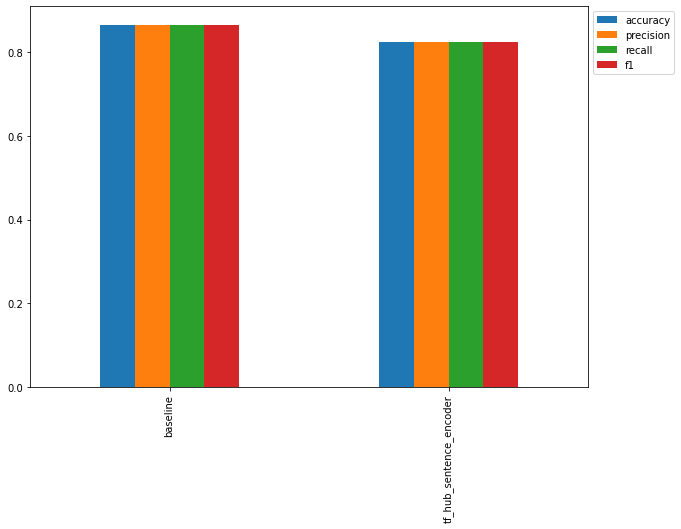

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Looks like our pretrained USE TensorFlow Hub models have the best performance. This goes to show the power of transfer learning.

How about we drill down and get the F1-score's of each model?

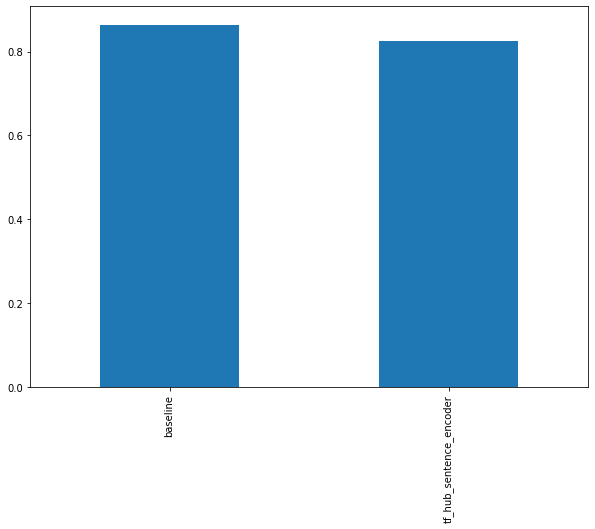

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Plot loss curves of the models

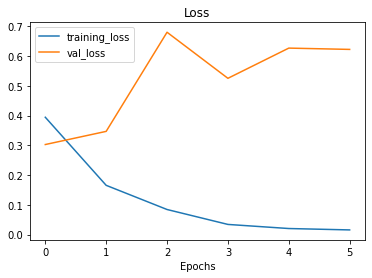

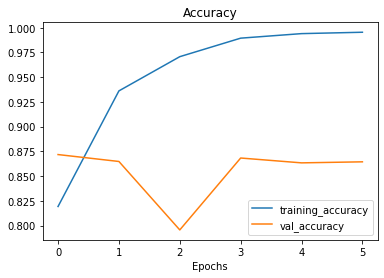

In [ ]:
plot_loss_curves(baseline_history)

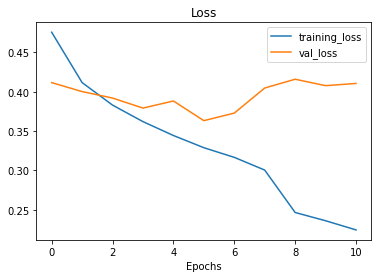

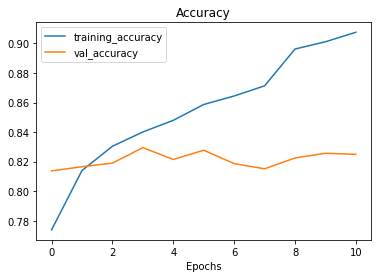

In [ ]:
plot_loss_curves(model_USE_history)

## Confusion Matrices

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

#  Helper function to plot Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='Accent'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[1250  239]
 [ 149 1224]]


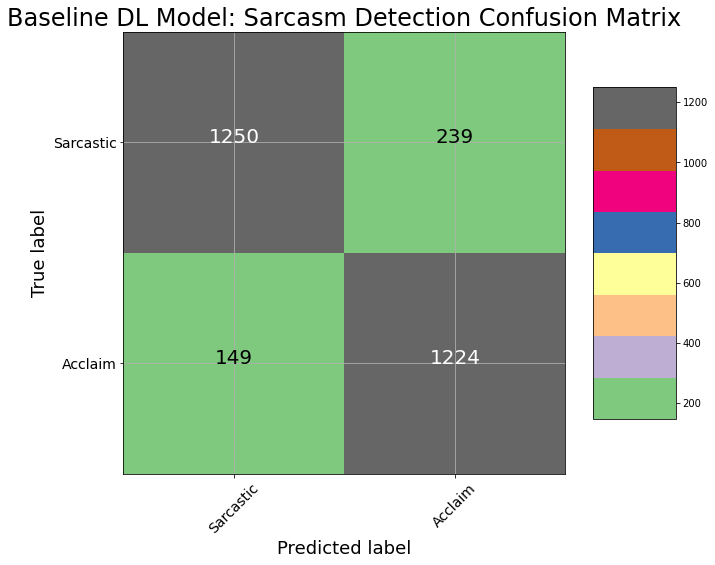

In [ ]:
cm_baseline = confusion_matrix(val_labels, baseline_model_preds)
plot_confusion_matrix(cm_baseline, classes = ['Sarcastic','Acclaim'],
                      title = 'Baseline DL Model: Sarcasm Detection Confusion Matrix')

Confusion matrix, without normalization
[[1226  263]
 [ 238 1135]]


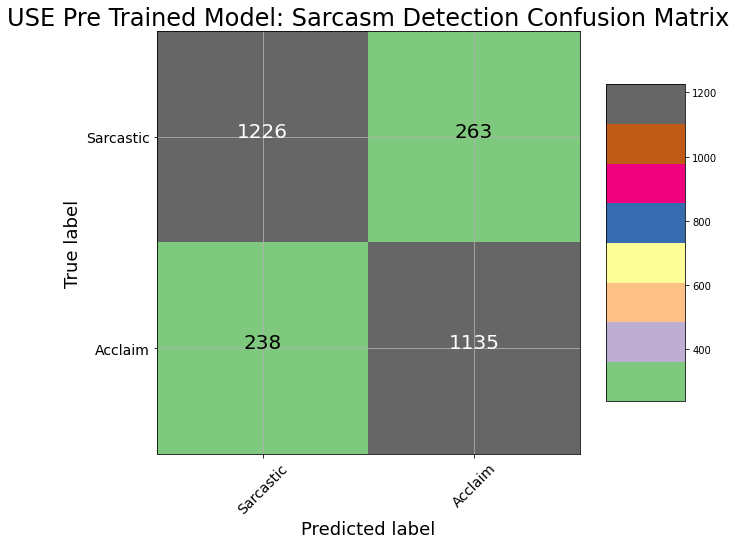

In [ ]:
cm_USE_model = confusion_matrix(val_labels, model_USE_preds)
plot_confusion_matrix(cm_USE_model, classes = ['Sarcastic','Acclaim'],
                      title = 'USE Pre Trained Model: Sarcasm Detection Confusion Matrix')

Drilling down into a single metric we see our USE TensorFlow Hub models performing  better than all of the other models. Interestingly, the baseline's F1-score isn't too far off the rest of the deeper models.

We can also visualize all of our model's training logs using TensorBoard.dev.

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "NLP modelling experiments" \
#   --description "A series of different NLP modellings experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

The TensorBoard logs of the different modelling experiments we ran can be viewed here: https://tensorboard.dev/experiment/LkoAakb7QIKBZ0RL97cXbw/

In [ ]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

## Saving and loading a trained model

Although training time didn't take very long, it's good practice to save your trained models to avoid having to retrain them.

Saving your models also enables you to export them for use elsewhere outside of your notebooks, such as in a web application.

There are two main ways of [saving a model in TensorFlow](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model):
1. The `HDF5` format. 
2. The `SavedModel` format (default).

Let's take a look at both.

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_USE.save("model_USE.h5")

If you save a model as a `HDF5`, when loading it back in, you need to let [TensorFlow know about any custom objects you've used](https://www.tensorflow.org/tutorials/keras/save_and_load#saving_custom_objects) (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).

In [ ]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_USE = tf.keras.models.load_model("model_USE.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model_USE.evaluate(val_sentences, val_labels)

90/90 [==============================] - 2s 19ms/step - loss: 0.4106 - accuracy: 0.8249


[0.4105527102947235, 0.8249475955963135]

Calling the `save()` method on our target model and passing it a filepath allows us to save our model in the `SavedModel` format. 

In [ ]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_USE.save("model_USE_SavedModel_format")

INFO:tensorflow:Assets written to: model_USE_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_USE_SavedModel_format/assets


If you use SavedModel format (default), you can reload your model without specifying custom objects using the [`tensorflow.keras.models.load_model()`](https://www.tensorflow.org/tutorials/keras/save_and_load) function.

In [ ]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_USE_SavedModel = tf.keras.models.load_model("model_USE_SavedModel_format")

In [ ]:
# Evaluate loaded SavedModel format
loaded_model_USE_SavedModel.evaluate(val_sentences, val_labels)

90/90 [==============================] - 2s 17ms/step - loss: 0.4106 - accuracy: 0.8249


[0.4105527400970459, 0.8249475955963135]

As you can see saving and loading our model with either format results in the same performance.

> 🤔 **Question:** Should you used the `SavedModel` format or `HDF5` format?

For most use cases, the `SavedModel` format will suffice. However, this is a TensorFlow specific standard. If you need a more general-purpose data standard, `HDF5` might be better. For more, check out the [TensorFlow documentation on saving and loading models](https://www.tensorflow.org/tutorials/keras/save_and_load).

## Finding the most wrong examples

We mentioned before that if many of our modelling experiments are returning similar results, despite using different kinds of models, it's a good idea to return to the data and inspect why this might be.

One of the best ways to inspect your data is to sort your model's predictions and find the samples it got *most* wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

Once again, visualization is your friend. Visualize, visualize, visualize.

To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

* If our best model still isn't perfect, what examples is it getting wrong? 
* Which ones are the *most* wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [ ]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_USE_preds,
                       "pred_prob": tf.squeeze(model_USE_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,verizon introduces new charge-you-at-whim plan,1,0.0,0.458337
1,florida man gets arrested with 'go directly to...,0,0.0,0.019524
2,barbara bush calls white house to see if she c...,1,1.0,0.981497
3,playstation classic to include friend who alwa...,1,1.0,0.995334
4,study: majority of frontal lobe occupied by th...,1,1.0,0.998893


Oh yeah! Now let's find our model's wrong predictions (where `target != pred`) and sort them by their prediction probability (the `pred_prob` column).

In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
1672,"exercise in your teen years pays off, accordin...",0,1.0,0.999528
328,"nigel, the lonely seabird, dies next to the co...",0,1.0,0.996225
798,gene simmons' message to wannabe rocker: 'get ...,0,1.0,0.995288
125,alia shawkat is feeling herself,0,1.0,0.992128
539,skittles highway spill reveals awful trend in ...,0,1.0,0.992047
1537,'people's couch' hunk gears up for the holiday...,0,1.0,0.988726
1992,"general mills releases tiny toast, its first n...",0,1.0,0.986578
1284,school official: laquan mcdonald lived a disad...,0,1.0,0.986482
232,chinese reporter rolled her eyes on state tele...,0,1.0,0.986309
1406,co-worker's bad mood getting you down? here's ...,0,1.0,0.985422


We can view the bottom end of our `most_wrong` DataFrame to inspect false negatives (model predicts 0, not a real diaster Tweet, when it should've predicted 1, real diaster Tweet).

Do you notice anything interesting about the most wrong samples?

Are the ground truth labels correct? What do you think would happen if we went back and corrected the labels which aren't?

## Making predictions on the new data

Alright we've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

Let's write some code to make predictions on random samples from the test dataset and visualize them.

## Predicting on Tweets from the wild

How about we find some Tweets and use our model to predict whether or not they're sarcastic or not?


In [ ]:
# Turn Tweet into string
chandlers_tweet = "I'm Not Great At The Advice. Can I Interest You In A Sarcastic Comment?"

Now we'll write a small function to take a model and an example sentence and return a prediction.

In [ ]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(sarcastic)" if pred_label > 0 else "(not sarcastic)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

Great! Time to test our model out.

In [ ]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_USE, # use the USE model
                    sentence=chandlers_tweet)

Pred: 0.0 (not sarcastic) Prob: 0.0009575786534696817
Text:
I'm Not Great At The Advice. Can I Interest You In A Sarcastic Comment?


In [ ]:
chandler_tweet_1 = "I’m glad we’re having a rehearsal dinner, I rarely practice my meals before I eat."


sheldon_tweet_1 = "Good morning everyone and welcome to 'Science and Society'. I'm Dr. Sheldon Cooper, BS, MS, MA, Ph.D., and ScD. OMG, right?"

In [ ]:
# Predict on Tweet 1
predict_on_sentence(model=model_USE, 
                    sentence=chandler_tweet_1)

Pred: 0.0 (not sarcastic) Prob: 0.11375834792852402
Text:
I’m glad we’re having a rehearsal dinner, I rarely practice my meals before I eat.


In [ ]:
# Predict on Sheldon Tweet 1
predict_on_sentence(model=model_USE, 
                    sentence=sheldon_tweet_1)

Pred: 0.0 (not sarcastic) Prob: 0.06656122952699661
Text:
Good morning everyone and welcome to 'Science and Society'. I'm Dr. Sheldon Cooper, BS, MS, MA, Ph.D., and ScD. OMG, right?


Looks like our model is performing as expected, predicting both of the sarcasm comments as actual sarcasm.

> 🔑 **Note:** The above examples are cherry-picked and are cases where you'd expect a model to function at high performance. For actual production systems, you'll want to continaully perform tests to see how your model is performing.